In [ ]:
jupyter-nbconvert --to slides "PuPPy - Pokemon Go KDTree.ipynb" --reveal-prefix=reveal.js --post serve

# Using KDTrees to calculate distances
## Or: the best coffee shop in Hong Kong for Pokemon

Michael Patterson

I work with spatial data, we use KDTrees all the time. Never heard of it before, so thought I'd present it.

Premise: you're a Pokemon Go player, and want to know the best place to catch Pokemon. For example, maybe you want to drink coffee, surf the internet and catch them.

In [1]:
import pandas as pd
import numpy as np
import json
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

# How can I find the closest coffee shop to each Pokemon in a city?
## The brute force method:
Calculate the distance between every pair of locations

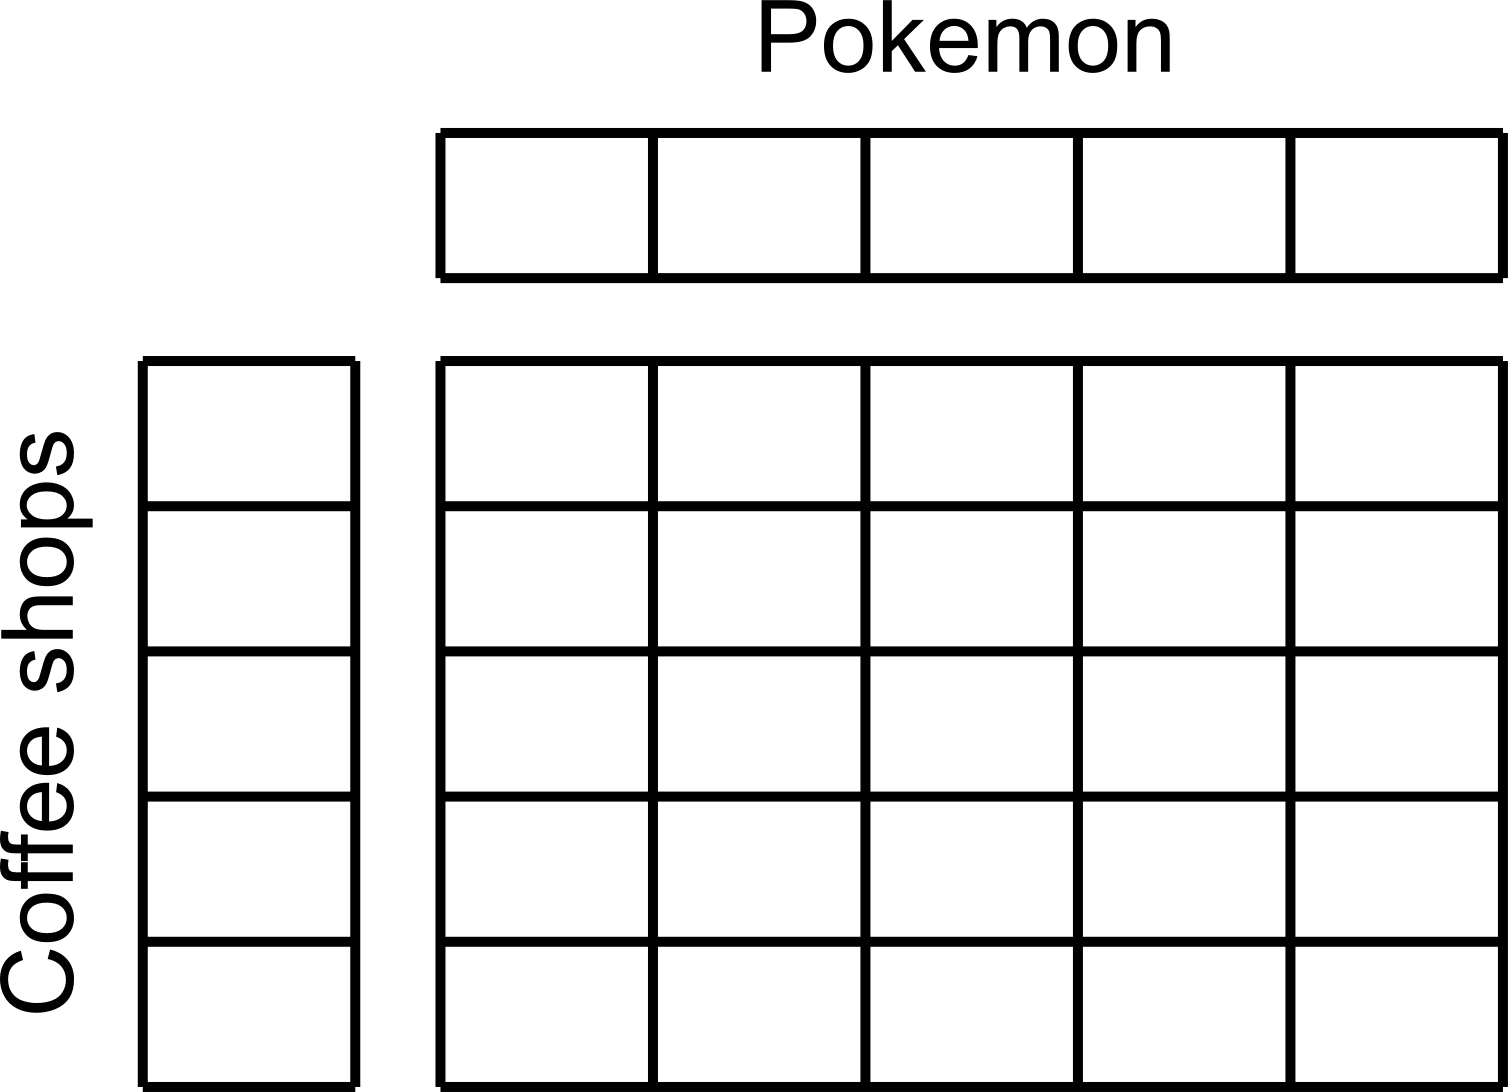

In [2]:
Image(filename= 'Distance grid.png', width=600) 

$Time\ complexity = P_{pokemon} * C_{coffee shops} \approx O(n^2)$

## KDTrees are much faster
$Build\ complexity = O(n\ log(n) )$

$Search\ complexity = O( log(n) )$

For our Pokemon example, if we used the trees to find the nearest coffeeshop for each pokemon, then our complexity would be:

$Time\ complexity = P_{pokemon} * log(C_{coffee shops}) \approx O(n\ log(n))$

## KDTrees are just multidimensional Binary Search Trees
For geographic information, this means the binary search tree alternates latitude (North / South) and longitude (East / West).

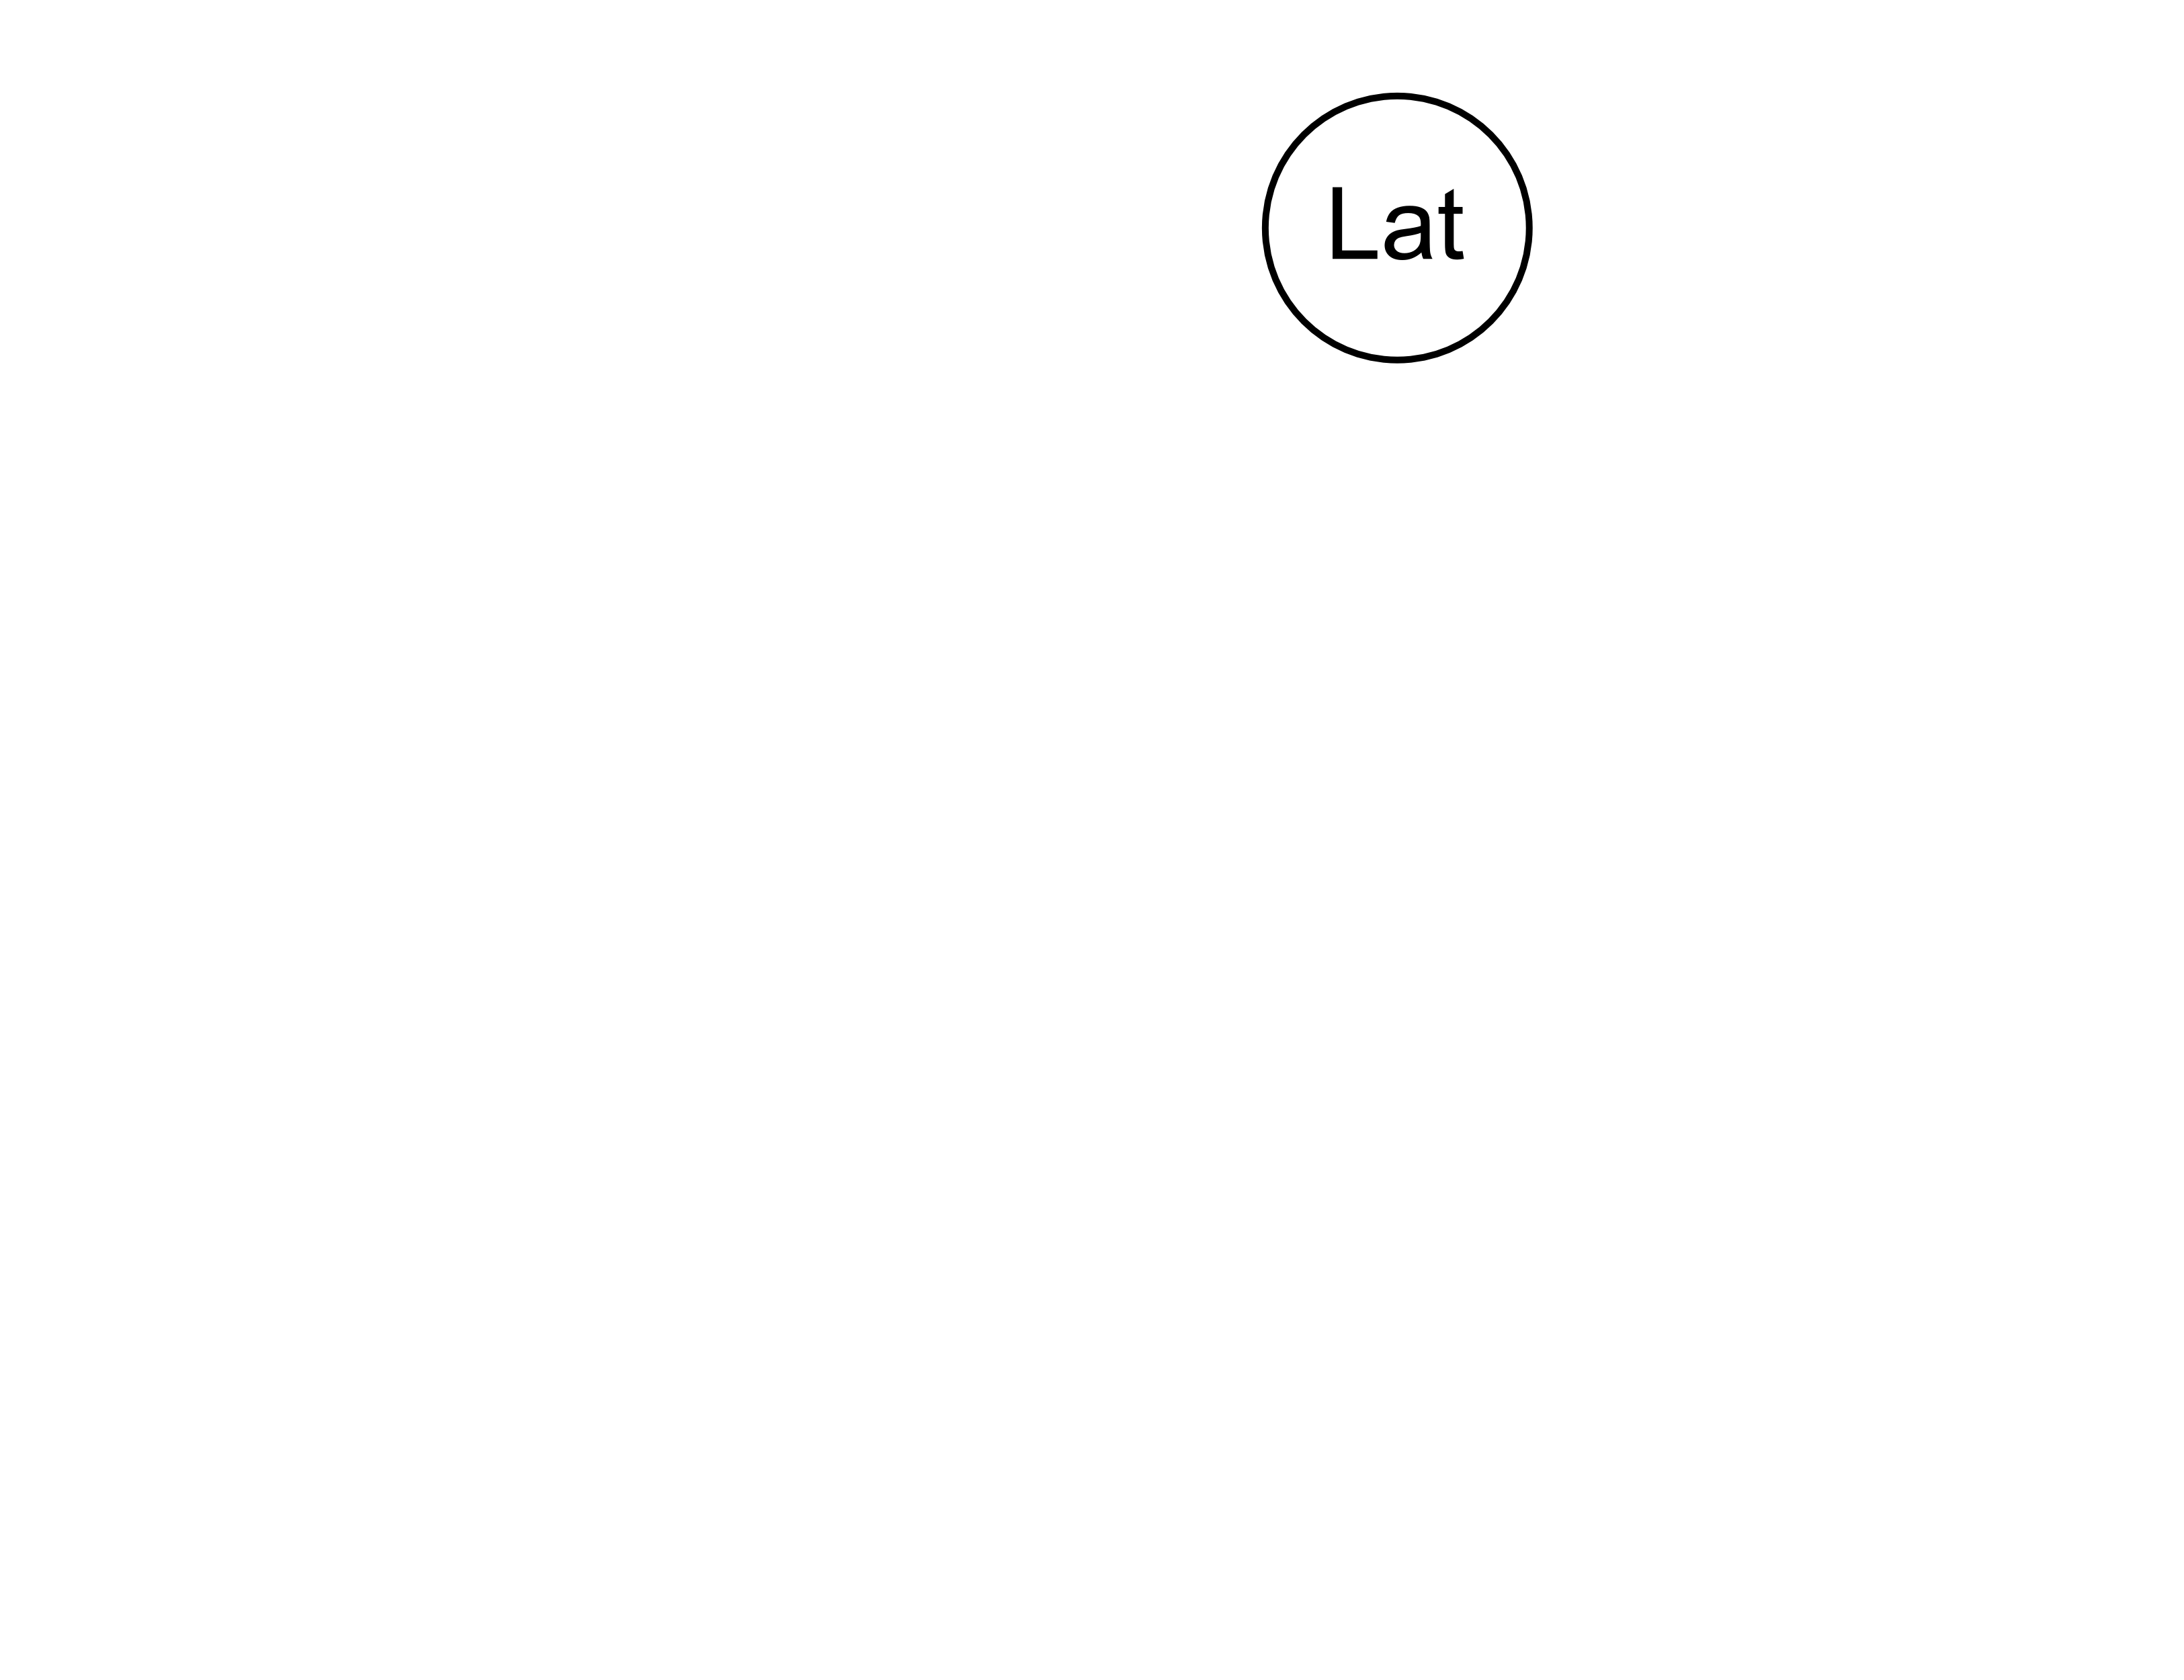

In [6]:
Image(filename= 'Root Tree.png', width=600) 

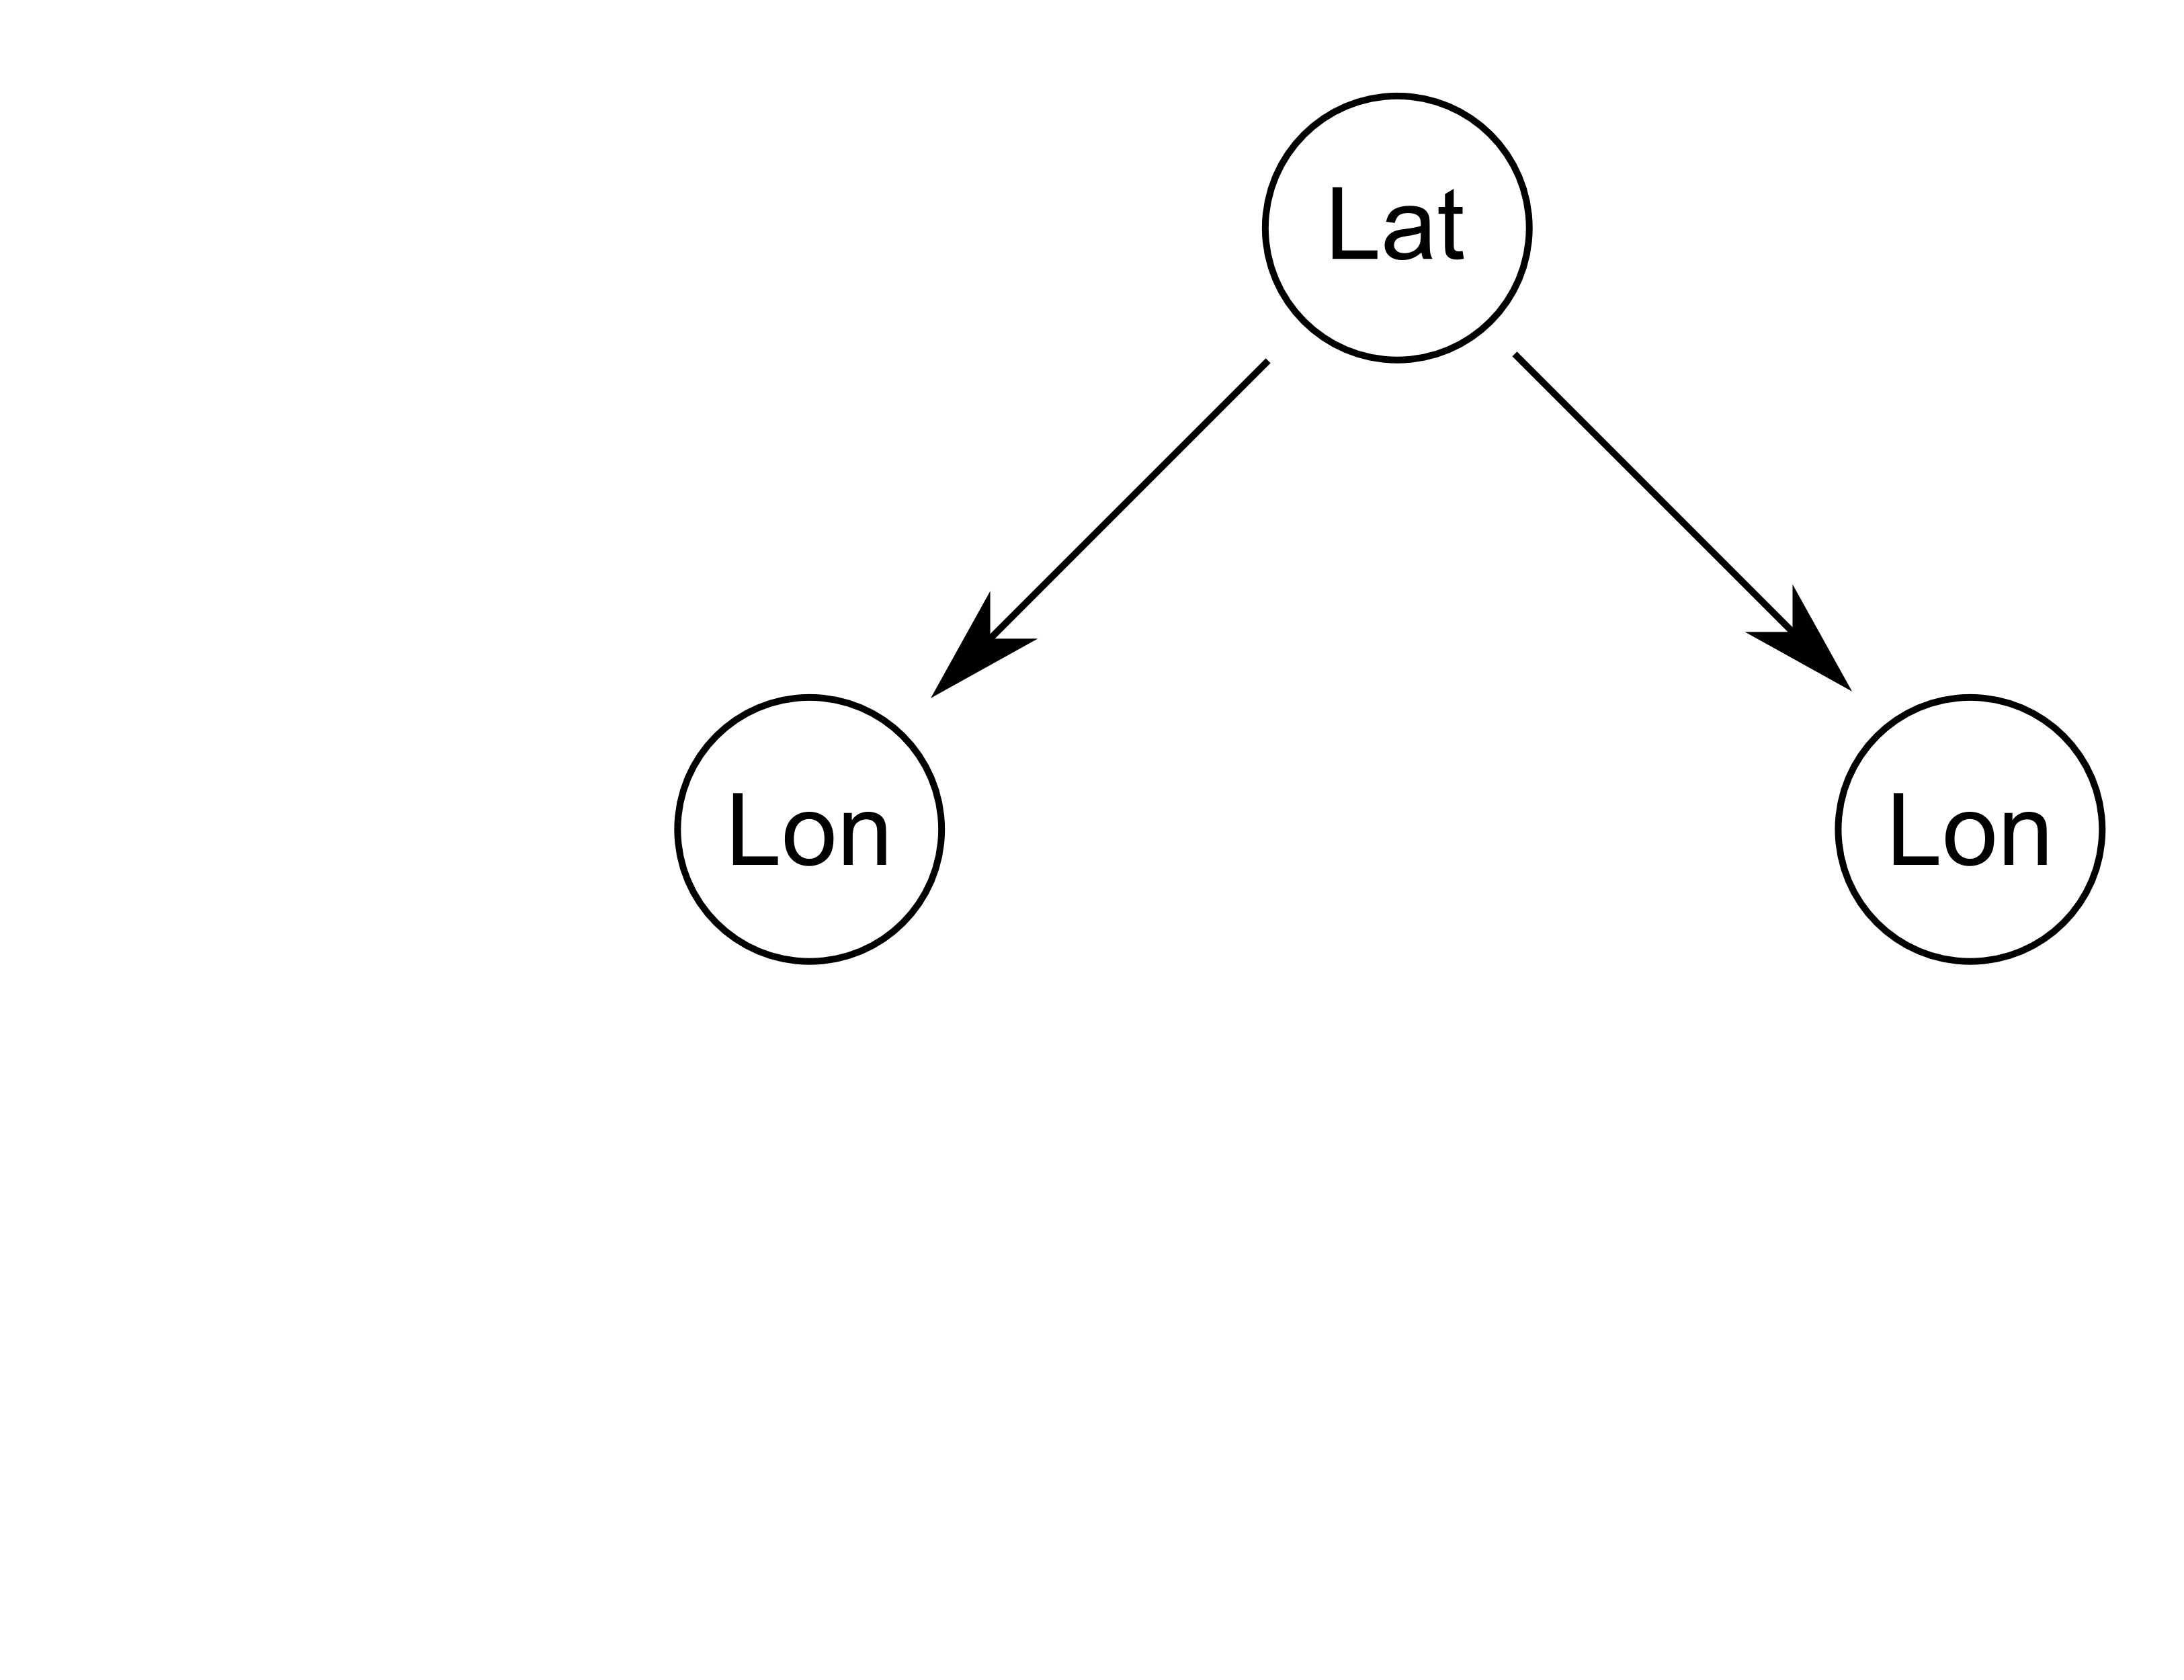

In [7]:
Image(filename= 'Half Tree.png', width=600) 

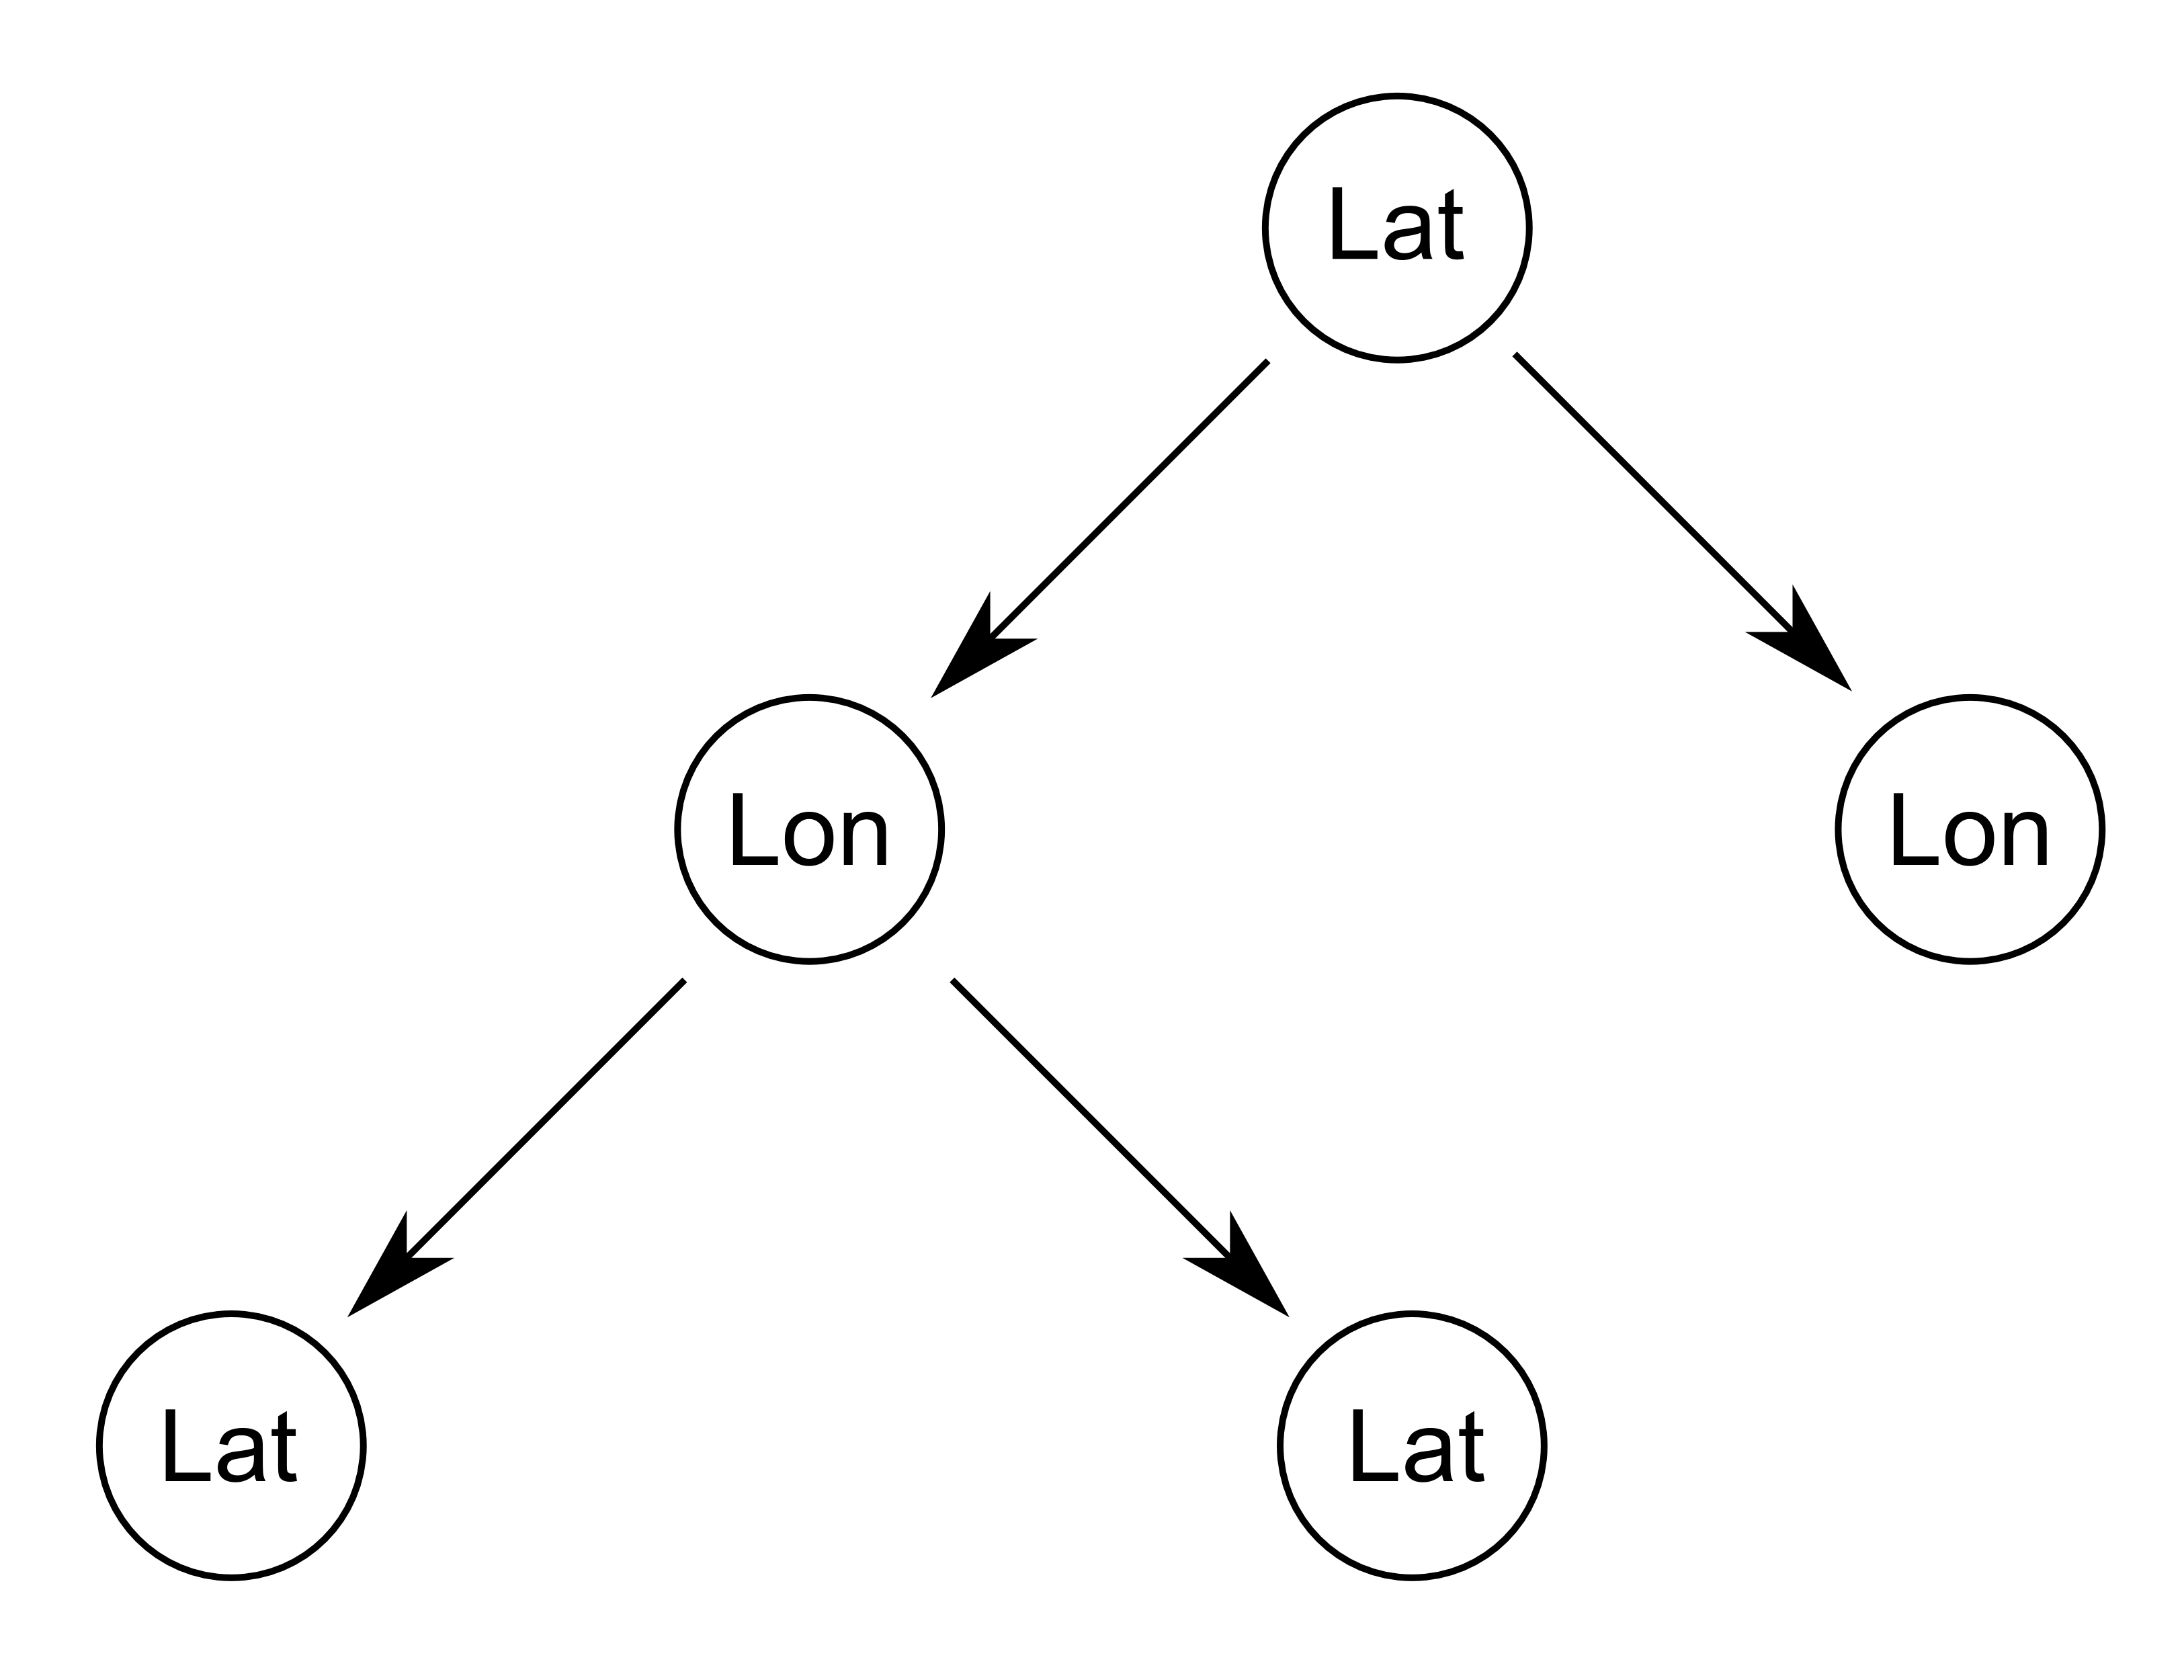

In [3]:
Image(filename= 'Full Tree.png', width=600) 

# Example of how a KDTree would find the closest coffee shop to a Pokemon

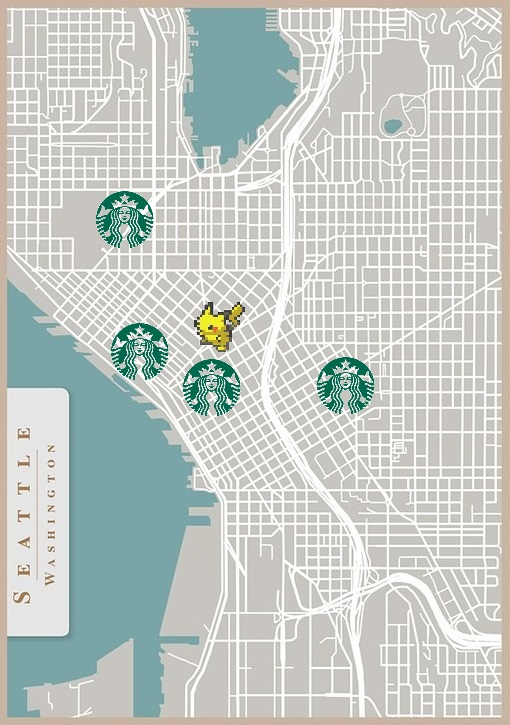

In [8]:
Image(filename= 'Seattle.jpg', width=600) 

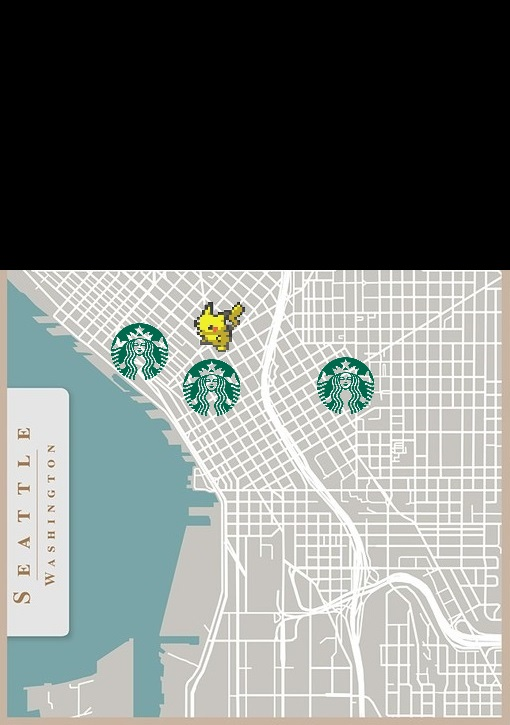

In [9]:
Image(filename= 'Seattle-2.jpg', width=600) 

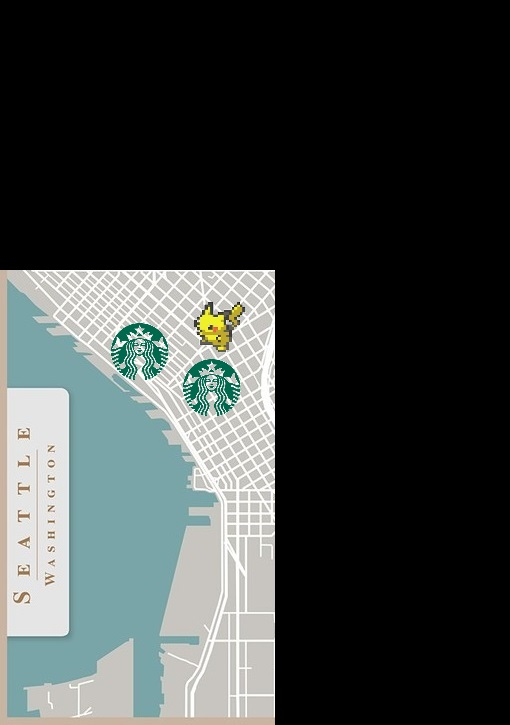

In [10]:
Image(filename= 'Seattle-3.jpg', width=600) 

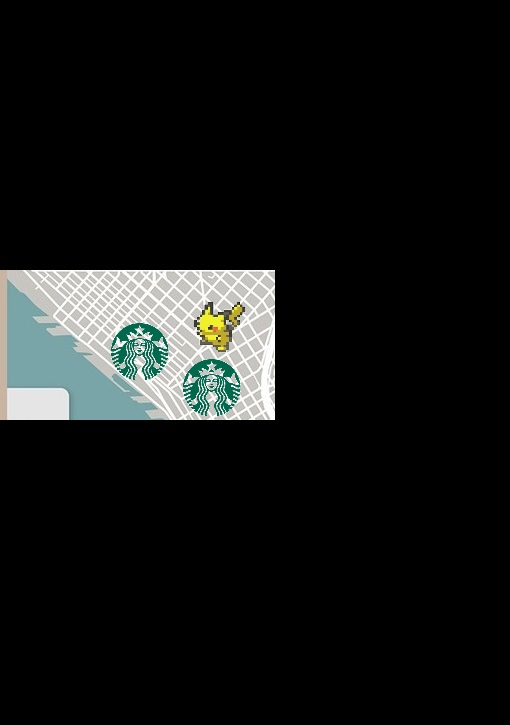

In [11]:
Image(filename= 'Seattle-4.jpg', width=600) 

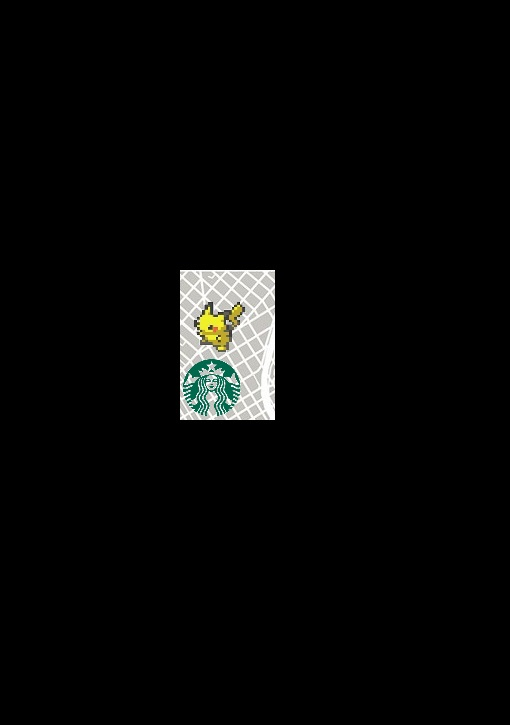

In [13]:
Image(filename= 'Seattle-5.jpg', width=600) 

<a id='load'></a>

## Load pokemon sightings
It was surprisingly hard to get pokemon data. I tried scraping the data myself, but Niantic (the developers of Pokemon Go) actively discourages that. In the end, I found the easiest place to get data was a Hong Kong Pokemon tracker, https://pokemon.appx.hk/. I visited that website ten times, and viewed the source code to get JSON objects with Pokemon locations (to get the locations, hit F12 to access the Source mode, then go to the Network tab, then the XHR sub-tab, and select the top element. If the `top` object is not there, try reloading the page with source view open).

After I downloaded the Pokemon location JSONs, I made the helper function below to load them using pandas, then created a single dataframe with all the data.

In [2]:
def load_poke_json( pokefile):
    return pd.read_json( pokefile ).rename(columns={'a':'lat', 'i':'type', 't':'ts', 'o':'lon'})

In [3]:
hk_poke_json = !ls hk-*.json
hk_poke_df = pd.concat(map(load_poke_json, hk_poke_json))
hk_poke_df.describe()

ia            id            is           lat           lon  \
count  10341.000000  10315.000000  10345.000000  16565.000000  16565.000000   
mean       8.035587      7.931265      7.989270     22.359070    114.120641   
std        4.325612      4.305660      4.281449      0.079485      0.098141   
min        1.000000      1.000000      1.000000     22.168887    113.843555   
25%        4.000000      4.000000      4.000000     22.294242    114.038069   
50%        8.000000      8.000000      8.000000     22.360883    114.135435   
75%       12.000000     12.000000     12.000000     22.425355    114.194700   
max       15.000000     15.000000     15.000000     22.553828    114.378200   

                 m1            m2           p            ts          type  
count  11044.000000  11044.000000   21.000000  1.656500e+04  16565.000000  
mean     221.798080     77.897320   41.047619  1.482486e+09     65.941020  
std       12.207434     33.937579   38.433678  7.234948e+05     34.650488  
min      200.000000     13.000000   16.000000  1.481390e+09      2.000000  
25%      210.000000     56.000000   16.000000  1.481742e+09     35.000000  
50%      222.000000     84.000000   19.000000  1.482811e+09     63.000000  
75%      234.000000    105.000000   41.000000  1.483210e+09     92.000000  
max      242.000000    133.000000  129.000000  1.483315e+09    149.000000

The data from appx.hk has four main columns of interest: pokemon type, lat, lon, and timestamp. I'm not sure what the `ia`, `id`, and `is` columns are for, since they are often null, and have no correlation with the other columns. There are over 16,000 pokemon sightings. We can use `value_counts` to find out which pokemon are most common.

In [4]:
hk_poke_df.type.value_counts().head()

35     2823
79     1361
102     866
27      766
42      758
Name: type, dtype: int64

In [5]:
(hk_poke_df.type.value_counts() < 10).sum()

32

The distribution of pokemon is highly skewed, with two types of Pokemon making up >30% of the total. Around 20% of Pokemon are so rare, they seen < 10 times.

Now that we have a single dataset, we can save it as a csv to load into PySpark. (You can actually load the data directly using `spark.create.DataFrame()`, but wanted to save the intermediate dataset so people don't have to remake it.)

In [6]:
hk_poke_df[['lat', 'lon', 'ts', 'type']].to_csv( 'hk_pokemon.csv', index = False, header = False)

## Load Hong Kong coffee locations
To get coffee shop locations, I queried the [FourSquare API](https://developer.foursquare.com/), using this [python package](https://pypi.python.org/pypi/foursquare/). As a free plug, I've found the FourSquare API has the most user friendly API of any review website. I adapted a [scraper function from another project](https://github.com/map222/Kibbeh/blob/master/src/API_io.py#L75) to get a list of Hong Kong coffee shops by lat / long.

I used the scraper to create a list of 586 coffee shops, and saved it into `hk_cofee.json`. (There are probably a lot more coffee shops, but refining the coffee shop scraper is beyond the scope of this notebook).

In [7]:
hk_coffee_df = pd.io.json.json_normalize( json.loads(open('hk_coffee.json').read() ) )[['location.lat', 'location.lng', 'name']]
hk_coffee_df.shape

(586, 3)

We can plot the locations of the coffee shops to make sure we have good coverage of the island. In the end, the easiest way for me to plot this was to use [this handy website.](http://www.darrinward.com/lat-long/) ![Hong Kong Coffee Shops](https://raw.githubusercontent.com/map222/trailofpapers/master/pokemon/HK%20Coffee.png)

After the locations are loaded, we can turn them into a scipy KDTree. Scipy has two types of KDTree in the library, compiled in python or C. I strongly recommend using the C version (cKDTree), as it is orders of magnitude quicker.

In [8]:
coffee_kdtree = cKDTree(hk_coffee_df[['location.lat', 'location.lng']] )

<a id='kdtree'></a>
# Querying KDTrees in Spark
Now that we have our Pokemon and coffee shop data processed, we can load the data into Spark! First, we can start by broadcasting the coffee_kdtree to all of the executors.

In [9]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
coffee_tree_broadcast = sc.broadcast( coffee_kdtree )

Next, we need to load the pokemon data into Spark. Here I define a simple schema using StructType, then load the pokemon csv using `spark.read.csv`, and finally `persist` the dataframe.

In [10]:
poke_schema = T.StructType([
                T.StructField('lat', T.FloatType(), False),
                T.StructField('lon', T.FloatType(), False),
                T.StructField('ts', T.FloatType(), False),
                T.StructField('type', T.IntegerType(), False)
                ])
poke_df = spark.read.csv('hk_pokemon.csv', schema = poke_schema).persist()

Finally, we need to make a function to query the KDTree. The function takes two columns from the DataFrame, and passes them through the KDTree one at a time.

In [11]:
def query_kdtree( lat, lon, cur_tree, radius = 0.0005):
    ''' query the kdtree to find locations within a radius of the lat / lon
        lat / lon: native python floats representing location
        cur_tree: a broadcast scipy cKDTree
        radius: radius, in degrees, around the pokemon to accept pokestops (default to ~50m)
    '''
    
    # a standard scipy cKDTree query, we want up to 10 coffeehouses within the radius of each pokemon
    query_results = cur_tree.value.query([lat, lon], 10, distance_upper_bound=radius)
    
    # query_results is a list of two arrays (radius, and index); we want to return the index
    # the index is a numpy integer which we needs to be cast as a python integer to return to Spark
    return [int(row[1]) for row in zip(*query_results) if row[0] < radius]

Since we are working in PySpark, we need to wrap the above function in a udf wrapper (user-defined function). The udf will be passed two columns, but we also need to set the KDTree as an argument. Here I use the `partial` function to pass `coffee_tree_broadcast`. You should also be able to use a `lambda` function to similar effect. Udf's require you to specify the return type. In this case, we are returning a list of integers, which are indices in the KDTree.

In [13]:
from functools import partial
coffee_udf = F.udf( partial(query_kdtree, cur_tree = coffee_tree_broadcast),
                    T.ArrayType( T.IntegerType() ) )

We're ready to pass the pokemon through the KDTree! To do so, we just need to add a column to the DataFrame using `withColumn`, applying the `coffee_udf`. Note that we can pass the lat and lon columns simply by naming them. After creating the new column, I use an `explode` statement to separate each shop into its own row. This should make the dataset tidier\*, as each row will represent one pokemon-shop combination.  Notice that after the explosion, the bottom two rows represent a single pokemon, and the two coffee shops it was near.

\*I think that's what tidy means.

In [13]:
nearby_df = (poke_df.withColumn('nearby_shops', coffee_udf('lat', 'lon'))
                    .select('*', F.explode('nearby_shops').alias('shop_index') ).persist() )
nearby_df.show(6)

+---------+---------+------------+----+------------+----------+
|      lat|      lon|          ts|type|nearby_shops|shop_index|
+---------+---------+------------+----+------------+----------+
|22.308178|113.91828|1.48331162E9|  27|         [0]|         0|
|22.207895|114.02905|1.48331187E9|  17|        [40]|        40|
|22.320929|113.94459|1.48331226E9|  56|        [17]|        17|
|22.205046|114.02998|1.48331162E9|  74|        [38]|        38|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        92|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        96|
+---------+---------+------------+----+------------+----------+
only showing top 6 rows



With this data we can answer some simple questions. For example, how many pokemon had a coffee shop nearby?

In [14]:
nearby_df.select('lat', 'lon', 'ts', 'type').distinct().count()

285

Or we can ask how many shops had at least one Pokemon nearby.

In [15]:
(nearby_df.select('shop_index').distinct().count() )

240

Finally, we can answer the question, which are the best coffee shops to catch pokemon? To do that, we can groupby store_index, and then aggregate by count. For display, we want to sort using `orderBy`.

In [16]:
(nearby_df.groupby('shop_index')
          .agg(F.count('shop_index').alias('num_pokemon'))
          .orderBy('num_pokemon', ascending = False).show(5) )

+----------+-----------+
|shop_index|num_pokemon|
+----------+-----------+
|        40|          6|
|        64|          5|
|       333|          5|
|       295|          5|
|       168|          5|
+----------+-----------+
only showing top 5 rows



To see which shops these are, we can go back to the original coffeshop dataframe.

In [17]:
hk_coffee_df.loc[[40, 64, 333, 295, 168]]

location.lat  location.lng                    name
40      22.207968    114.029331         Coffee Seeds 阿翁
64      22.270550    114.130811  Pacific Coffee (太平洋咖啡)
333     22.318484    114.174676               Starbucks
295     22.296741    114.169362               Starbucks
168     22.283222    114.159201               Starbucks

It turns out the best place is a [local place on a tiny southern island](https://foursquare.com/v/coffee-seeds-%E9%98%BF%E7%BF%81/4f547dbfe4b0bf6b5f624b57/)!

In [18]:
hk_coffee_df.name.str.startswith('Starbucks').sum()

150

For kicks, we can also see how many were Starbucks. 150 out of 580! This probably reflects the limitations of our original dataset, as we scraped the coffee shop locations using Four Square. If anyone has a better coffee shop list, let me know!

<a id='rdd'></a>
# Performance of DataFrames vs RDDs
If you go to any Spark workshop or meetup, you will inevitably be told that DataFrames are a lot faster and easier to work with than RDDs. While this dataset is a probably too small for a proper investigation, I thought I'd run some benchmarks to see. To start with, let's see how fast the query is using DataFrames.

In [14]:
%time (poke_df.repartition(1).withColumn('nearby_shops', coffee_udf('lat', 'lon')).count() )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.68 s


16565

1.7 seconds for our 16,000 locations using DataFrames. For RDDs, we can write a similar function, and `map` it.

In [15]:
def query_kdtree_rdd( row, map_tree, radius = 0.0005):
    # first we need to convert the row to a dictionary
    cur_row = row.asDict()
    
    # pass the dictionary through the KDTree
    query_results = map_tree.value.query([row['lat'], row['lon']], 10, distance_upper_bound=radius)
    
    # then convert the results back into a dictionary / row
    cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
    return Row(**cur_row)

In [16]:
%time poke_df.rdd.map(partial(query_kdtree_rdd, map_tree = coffee_tree_broadcast)).count()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.62 s


16565

Only a little bit slower! What if we use `mapPartitions`, which processes an entire partition in one go?

In [17]:
# naive mapPartitions
def query_kdtree_mappartitions(iterator):
    radius = 0.0005
    new_rows = []
    for row in iterator:
        cur_row = row.asDict()
        query_results = coffee_tree_broadcast.value.query([cur_row['lat'], cur_row['lon']], 10, radius)
        cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
        new_rows.append(Row(**cur_row))
    return new_rows

In [18]:
%time poke_df.rdd.mapPartitions(query_kdtree_mappartitions).count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.09 s


16565

30% faster! In previous KDTree benchmarks I've tried, the DataFrame method is ~2x faster than the mapPartitions method. My guess is that this dataset is small enough that the advantages of DataFrames can't shine through. 


## Conclusion
Anyway, this is one way to use KDTrees in PySpark! Some of the key general concepts for me were:
1. Learning how to define `UDF`s on multiple columns of data
2. Figuring out how to pass the KDTree to the function using `partial`
3. Being careful to return native python types, and using the right DataTypes
    
Good Pokehunting and tree searching!